# Problem Session 02
## Classifying Pumpkin Seeds

In this notebook we will utilize the following tools we learned about in lecture `01_supervised_learning`:

- Obtaining data
- Data cleaning
- Exploratory Data Analysis
- Modeling
- Pipelines
- Basic model evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

#### 1. Load the data

##### a.

First load the data stored in `Pumpkin_Seeds_Dataset.xlsx` in the `data` folder.

Note you will want to use the `read_excel` function from `pandas`, <a href="https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html?highlight=read_excel">https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html?highlight=read_excel</a>. Print a random sample of five rows.

##### Sample Solution

In [2]:
seeds = pd.read_excel("../../data/Pumpkin_Seeds_Dataset.xlsx")

In [3]:
seeds.sample(5)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
2412,82347,1196.735,503.6530,209.0714,83084,323.8016,0.9098,0.9911,0.7189,0.7225,2.4090,0.6429,Ürgüp Sivrisi
2197,87144,1190.491,486.8490,228.9883,88042,333.0994,0.8825,0.9898,0.6038,0.7727,2.1261,0.6842,Ürgüp Sivrisi
2434,97097,1262.071,521.6305,238.0981,98195,351.6074,0.8897,0.9888,0.5708,0.7660,2.1908,0.6741,Ürgüp Sivrisi
2202,85763,1137.091,454.0440,241.3613,86401,330.4495,0.8470,0.9926,0.6540,0.8335,1.8812,0.7278,Ürgüp Sivrisi
1094,86421,1137.192,452.7063,243.6435,87110,331.7147,0.8428,0.9921,0.7531,0.8398,1.8581,0.7327,Çerçevelik


##### b.

Create a new column of the `DataFrame` called `y` where `y=1` if `Class=Ürgüp Sivrisi` and `y=0` if `Class=Çerçevelik`.

##### Sample Solution

In [4]:
seeds['y'] = 0

seeds.loc[seeds.Class=='Ürgüp Sivrisi', 'y']=1

#### 2. Learn about the data

##### a.

These data represent various measurements of pumpkin seeds that come from high quality photos of the seeds. The data was provided as supplementary material to <a href="https://link.springer.com/article/10.1007/s10722-021-01226-0">The use of machine learning methods in classification of pumpkin seeds (Cucurbita pepo L.)</a> by Koklu, Sarigil and Ozbek (2021).

In this work the researchers demonstrated how various algorithms could be used to predict whether a pumpkin seed was a Ürgüp Sivrisi seed or a Çerçevelik seed. These data were generated by engineering features from special photos of seeds like so:
<br>
<br>
<img src="problem_session_assets/pumpkin_seeds.jpg" width="55%"></img>

As you can see these two seeds can be quite difficult for the human eye to discern, hence the appeal to machine learning algorithms.

A PDF of this paper is provided here, <a href="problem_session_assets/pumpkin_seed_paper.pdf">pumpkin_seed_paper.pdf</a>. Scroll down to Figure 5 and Table 1 and read about the features of this data set.

#### 3. Train test split

##### a.

Look at how the data is split between the two classes. Does this appear to be imbalanced data? <i>Recall that we say data is imbalanced if one of the classes has a very small presence in the data set.

##### Sample Solution

In [5]:
seeds.Class.value_counts(normalize=True)

Class
Çerçevelik       0.52
Ürgüp Sivrisi    0.48
Name: proportion, dtype: float64

This data set seems pretty well balanced.

##### b.

Make a train test split, set aside $20\%$ of the data as the test set.  You should stratify with respect to the target to ensure class balance.

##### Sample Solution

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
seeds_train, seeds_test = train_test_split(seeds,
                                              shuffle=True,
                                              random_state=123,
                                              test_size=.1,
                                              stratify=seeds.y)

To compare different candidate models we will use a single *validation set*.  Further split the training set into training and validation sets.

In [8]:
seeds_tt, seeds_val = train_test_split(seeds_train,
                                              shuffle=True,
                                              random_state=123,
                                              test_size=.1,
                                              stratify=seeds_train.y)

#### 4. Exploratory data analysis (EDA)

Before building any models you will do some EDA.

##### a. 

One way to try and identify key features for classification algorithms is to plot histograms of the feature values for each of the classes.

Below is an example of such a histogram for the `Area` column made using `plt.hist`.

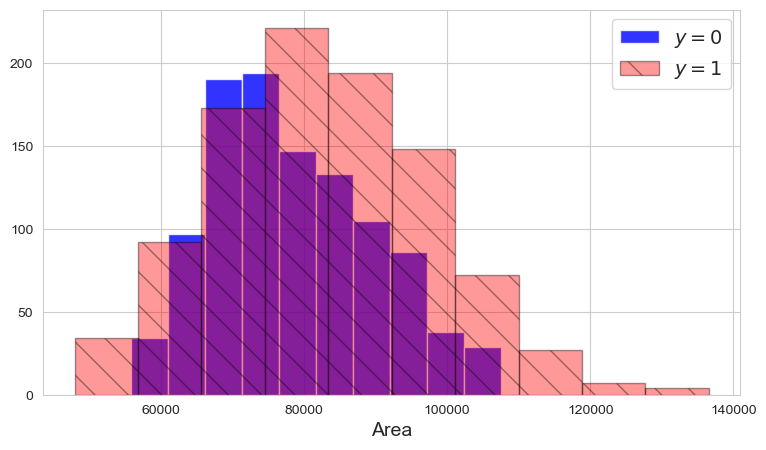

In [9]:
plt.figure(figsize=(9,5))


plt.hist(seeds_tt.loc[seeds_tt.y==0].Area,
            color='blue',
            alpha=.8,
            label="$y=0$")

plt.hist(seeds_tt.loc[seeds_tt.y==1].Area,
            color='red',
            alpha=.4,
            hatch = '\\',
            edgecolor='black',
            label="$y=1$")

plt.xlabel("Area", fontsize=14)
plt.legend(fontsize=14)

plt.show()

In this plot we can see that the two histograms are right on top of one another, indicating that the two classes of pumpkin seeds tend to have similar areas. This suggests that `Area` may not be a useful variable for discerning the seed class.

Use a `for` loop or some comparable method to produce similar histograms for each of the features. Write down the features that look like they may be useful for classification.

##### Sample Solution

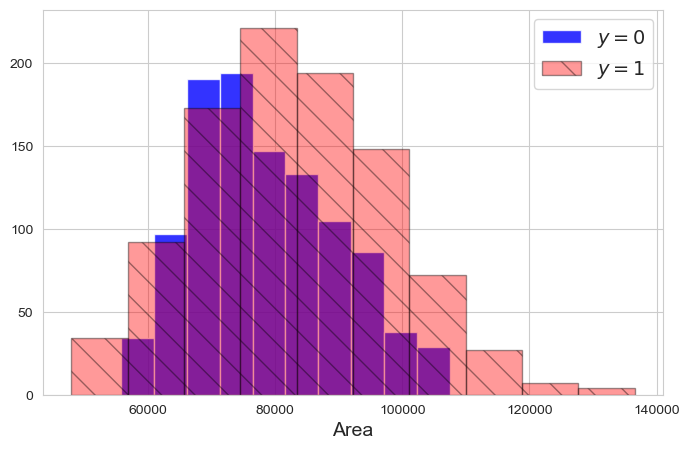

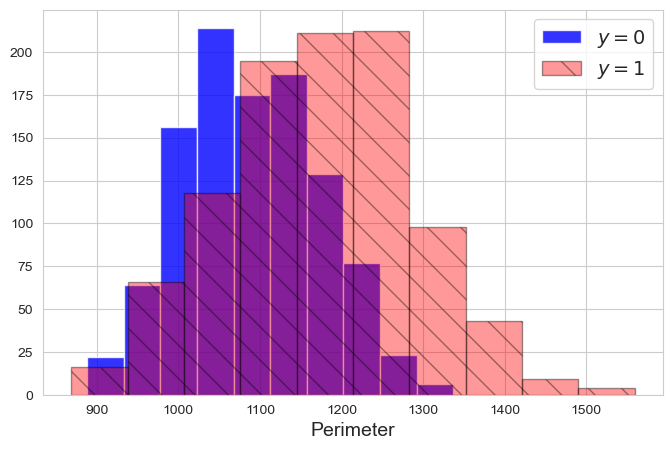

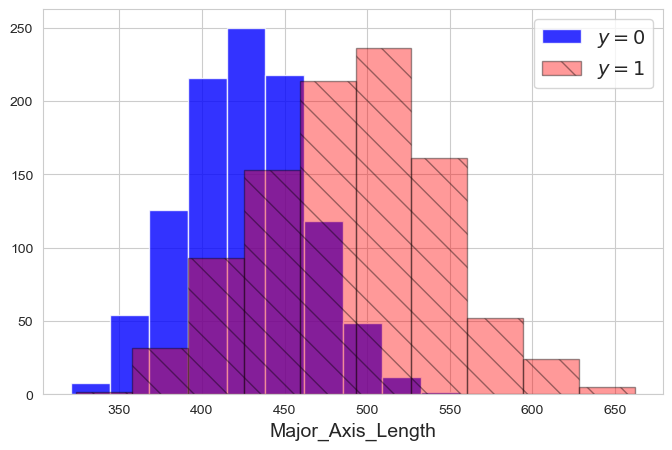

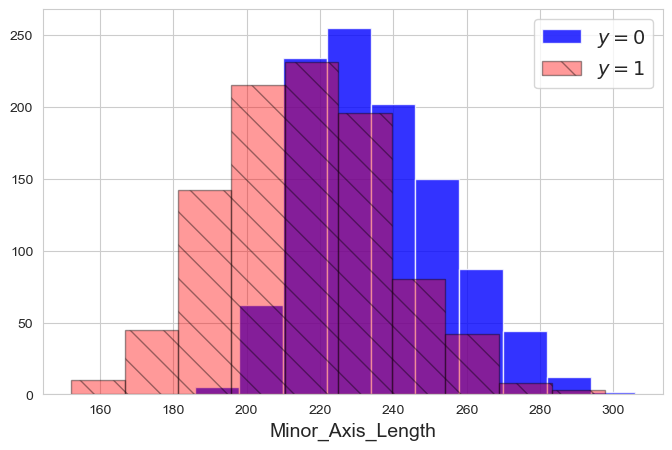

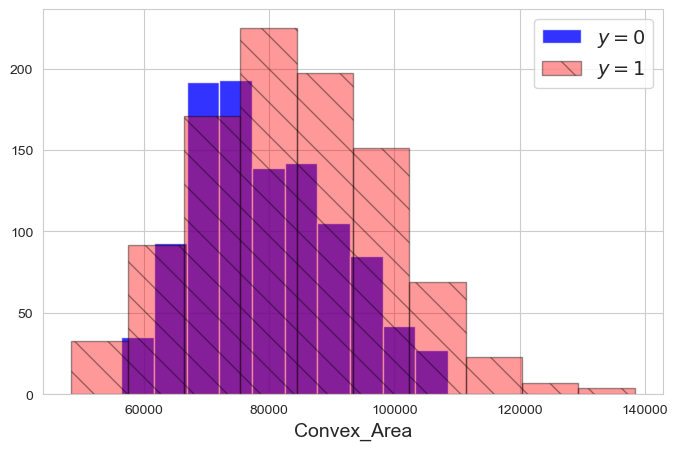

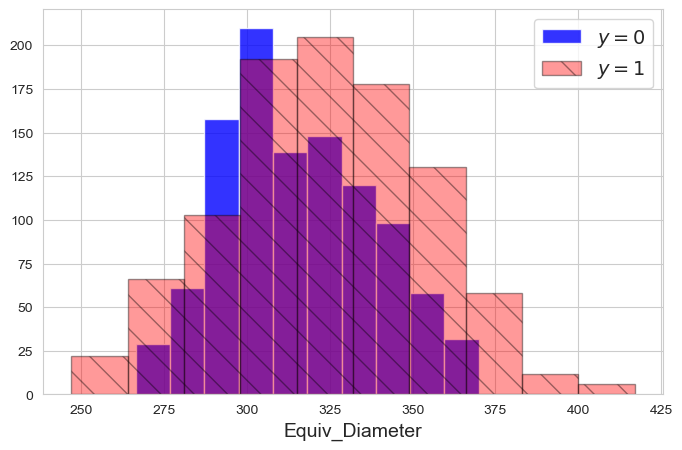

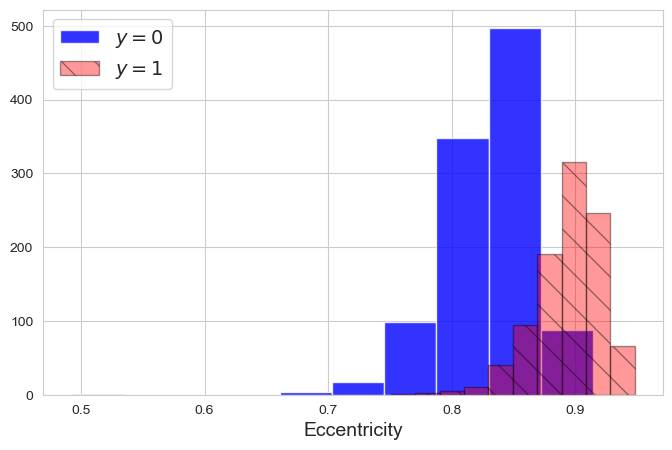

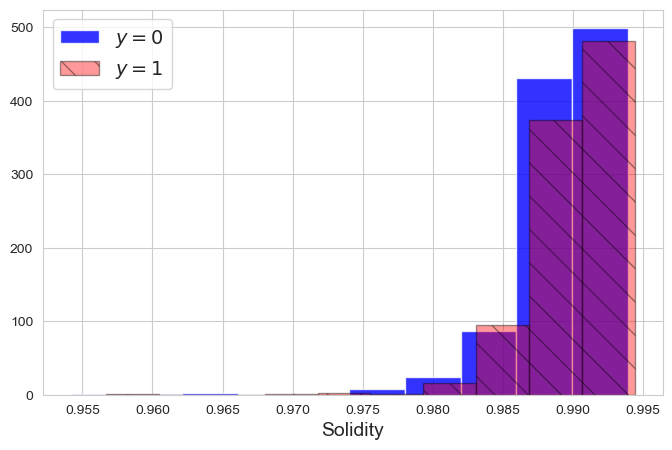

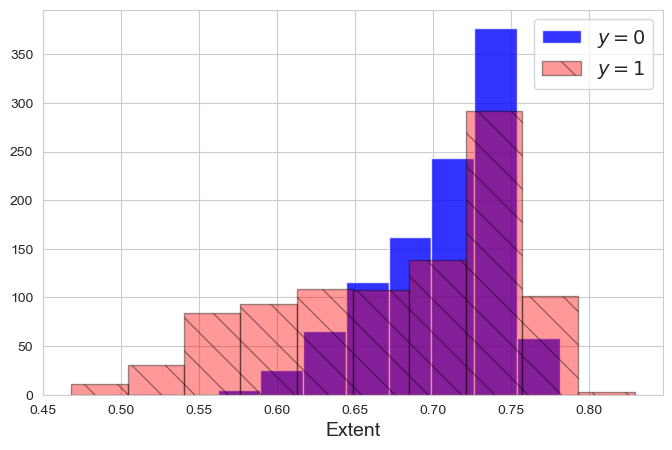

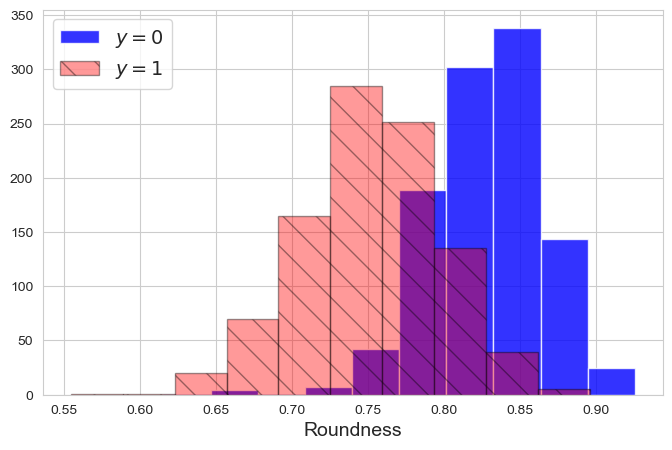

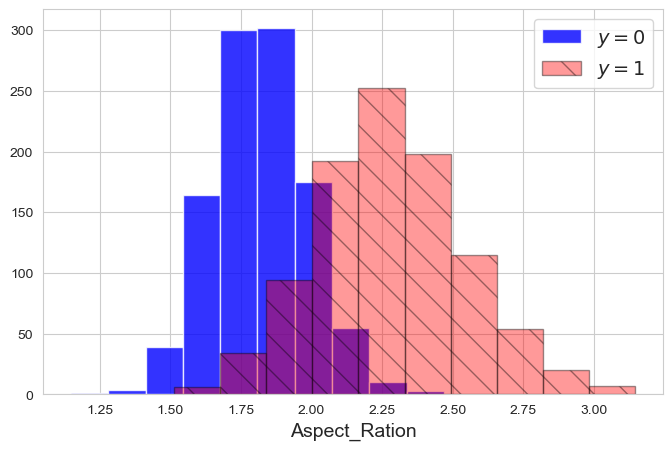

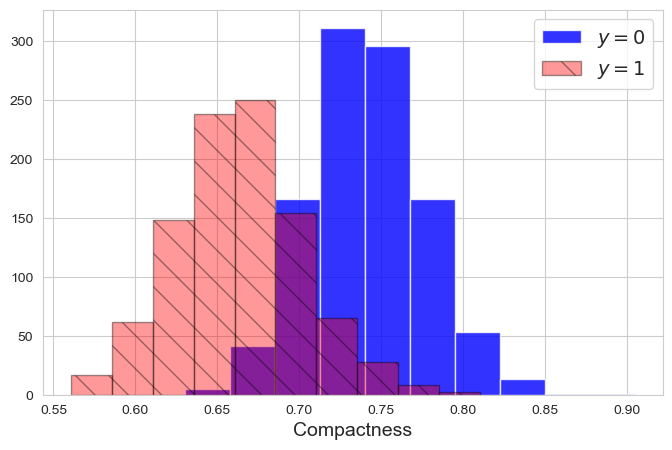

In [10]:
for col in seeds_tt.columns[:-2]:
    plt.figure(figsize=(8,5))


    plt.hist(seeds_tt.loc[seeds_tt.y==0, col],
                color='blue',
                alpha=.8,
                label="$y=0$")

    plt.hist(seeds_tt.loc[seeds_tt.y==1, col],
                color='red',
                alpha=.4,
                hatch = '\\',
                edgecolor='black',
                label="$y=1$")

    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

These features seem like they may be useful in classifying the seeds.
- `Major_Axis_Length`
- `Eccentricity`
- `Roundness`
- `Aspect_Ration`
- `Compactness`

##### b.

Now try making a `seaborn` `pairplot` using the variables you identified in part <i>a.</i> as the arguments for `x_vars` and `y_vars`. Use `y` as the argument to `hue`. The main goal with this question is to see if you can identify any pairs of variables that seem to separate the two classes. You will use these plots later in the notebook.

##### Sample Solution

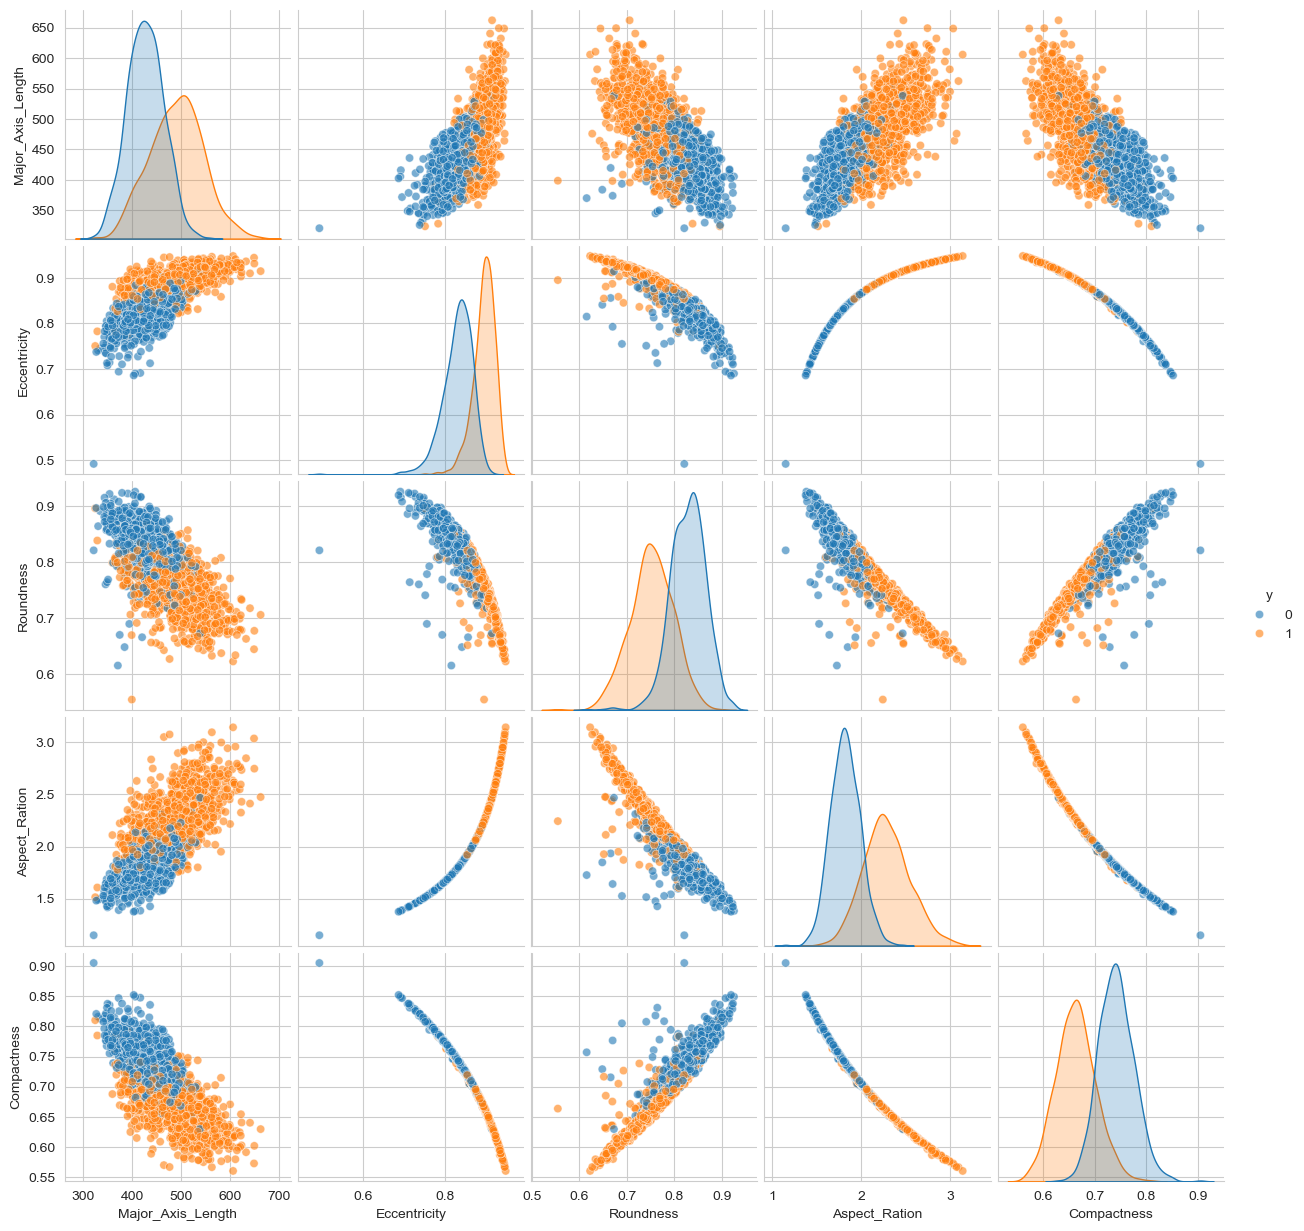

In [11]:
sns.pairplot(data = seeds_tt,
                x_vars = ['Major_Axis_Length', 'Eccentricity', 
                              'Roundness', 'Aspect_Ration', 'Compactness'],
                y_vars = ['Major_Axis_Length', 'Eccentricity', 
                              'Roundness', 'Aspect_Ration', 'Compactness'],
                hue = 'y',
                plot_kws = {'alpha':.6})

plt.show()

Note that it appears that there is an exact functional relationship between `Aspect_Ration`, `Compactness`, and `Eccentricity`.  We should include at most one of these features in our model.

I am going to select the features `Major_Axis_Length`, `Compactness`, and `Roundness`.

#### 5. Metric selection

In the remainder of this notebook you will make some initial models.

##### a.

Now that you have read about the data and looked at the split between the two classes what seems like a reasonable performance metric for this problem? Explain your answer.

##### Sample Solution

For this problem accuracy is probably a good metric. The classes are well balanced so we will not get an artificially high accuracy and without knowing of any major differences between the two types of pumpkin seeds there is no reason to focus on the proper classification of one of the classes over the other.

##### b.

Recalling that `y=1` implies that the seed is of the Ürgüp Sivrisi class and `y=0` implies that the seed is of the Çerçevelik class, what do the following metrics measure in the context of this classification problem:
- recall
- precision
- false positive rate.

##### Sample Solution

- recall measures what fraction of observations that are actually a 1 are predicted to be a 1. In this context that would mean the fraction of seeds we correctly identify to be of the Ürgüp Sivrisi class.
- precision measures what fraction of the predicted 1s are actually 1s. In this context that means the fraction of predicted Ürgüp Sivrisi seeds are actually Ürgüp Sivrisi seeds.
- fpr measures the fraction of actual $0$s that are incorrectly predicted to be 1. In this setting that means the fraction of Çerçevelik seeds that are classified as Ürgüp Sivrisi seeds.


#### 6. Initial modeling attempts

In the remainder of this notebook you will make some initial models.

##### a.

You will train each model using `seeds_tt`.  You will the evaluate the accuracy of each model on `seeds_val`.  We don't touch the final test set until we are satisfied with the performance of one of our models.

Since [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) has some default L2 regularization it *is* sensitive to the scale of the data.  We could just turn that off with `penalty = False`.  To give you some practice with pipelines, instead put the logistic regression models in [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Also compare to the baseline [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) model which just predicts the most frequent class.

##### Sample Solution

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.base import clone


In [13]:
features = ['Major_Axis_Length', 'Compactness', 'Roundness']

model_names = ['baseline', 'major_axis_length_model', 'compactness_model', 'roundness_model']

# map each model to its single feature (baseline uses none)
feature_map = {
    'baseline': None,
    'major_axis_length_model': 'Major_Axis_Length',
    'compactness_model': 'Compactness',
    'roundness_model': 'Roundness',
}

# base estimators (cloned per fit to avoid state carryover)
base_models = {
    'baseline': DummyClassifier(strategy="most_frequent"),
    'major_axis_length_model': Pipeline([('scale', StandardScaler()), ('log',LogisticRegression(max_iter=1000))]),
    'compactness_model': Pipeline([('scale', StandardScaler()), ('log',LogisticRegression(max_iter=1000))]),
    'roundness_model': Pipeline([('scale', StandardScaler()), ('log',LogisticRegression(max_iter=1000))]),
}

model_accs = {name: None for name in model_names}

for name in model_names:
    model = clone(base_models[name])
    feat = feature_map[name]

    X_tt = seeds_tt[[feat]] if feat is not None else seeds_tt[[]]
    y_tt = seeds_tt.y

    X_val = seeds_val[[feat]] if feat is not None else seeds_val[[]]
    y_val = seeds_val.y

    model.fit(X_tt, y_tt)
    pred = model.predict(X_val)

    model_accs[name] = accuracy_score(y_val, pred)


In [14]:
model_accs

{'baseline': 0.52,
 'major_axis_length_model': 0.7644444444444445,
 'compactness_model': 0.8355555555555556,
 'roundness_model': 0.8}

Of these three features, "Compactness" is the best.

##### c.

Compare these models to the logistic regression model that incorporates all of the features you identified with your histogram exploration.

##### Sample Solution

In [15]:
log_reg = Pipeline([('scale', StandardScaler()), ('log',LogisticRegression(max_iter=1000))])
    
log_reg.fit(seeds_tt[features],seeds_tt.y)
    
pred = log_reg.predict(seeds_val[features])

full_log_acc = accuracy_score(seeds_val.y,pred)

full_log_acc

0.8533333333333334

In [16]:
full_log_acc

0.8533333333333334

The compactness only model and the model using all three variables are performing almost identically.  Since the compactness only model is simpler this would be my top model at the moment.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)